In [1]:
import sys
from tqdm import tqdm
sys.path.append('..')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from data.energy_data import EnergyDataset
from models.lstm import LSTM

In [2]:
timeseries = pd.read_csv('../data/data_preprocessed.csv')
timeseries = timeseries[['_value']]

In [3]:
train_dataset = EnergyDataset('../data/train.csv', window_size=4)
test_dataset = EnergyDataset('../data/test.csv', window_size=4)

train_loader = DataLoader(train_dataset, batch_size=8, drop_last=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, drop_last=True, shuffle=False)

In [4]:
model = LSTM(input_size=1, hidden_size=50, num_layers=1, output_size=1)
optimizer = optim.Adam(model.parameters())
loss_function = nn.MSELoss()

In [5]:
n_epochs = 100

for i in range(n_epochs):
    model.train()
    for x_batch, y_batch in tqdm(train_loader):
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    if i % 10 == 0:
        model.eval()
        with torch.no_grad():
            mse_list = []
            for x_test, y_test in test_loader:
                with torch.no_grad():
                    y_pred = model(x_test)
                    train_rmse = np.sqrt(loss_function(y_pred, y_test))
                    y_pred = model(x_batch)
                    loss = loss_function(y_pred, y_test).item()
                    mse_list.append(loss)
            
            mse = sum(mse_list) / len(mse_list)
            print("Epoch %d: test MSE %.4f" % (i, mse))


100%|██████████| 3502/3502 [00:05<00:00, 593.35it/s]


Epoch 0: test RMSE nan


100%|██████████| 3502/3502 [00:05<00:00, 598.69it/s]


Epoch 10: test RMSE nan


 89%|████████▉ | 3125/3502 [00:05<00:00, 563.80it/s]


KeyboardInterrupt: 

In [25]:
X_train, y_train = train_dataset.return_X_y()
X_test, y_test = test_dataset.return_X_y()

with torch.no_grad():
    # shift train predictions for plotting
    y_pred_train = model(X_train)[:,-1,:]
    y_pred_test = model(X_test)[:,-1,:]

print(y_pred_train.shape, y_pred_test.shape, y_pred_test.shape[0] + y_pred_train.shape[0])

torch.Size([27202, 1]) torch.Size([6798, 1]) 34000


In [50]:
model(X_test).shape

torch.Size([6798, 4, 1])

In [27]:
y_pred = torch.cat([y_pred_train, y_pred_test], dim=0)
y_pred.shape

torch.Size([34000, 1])

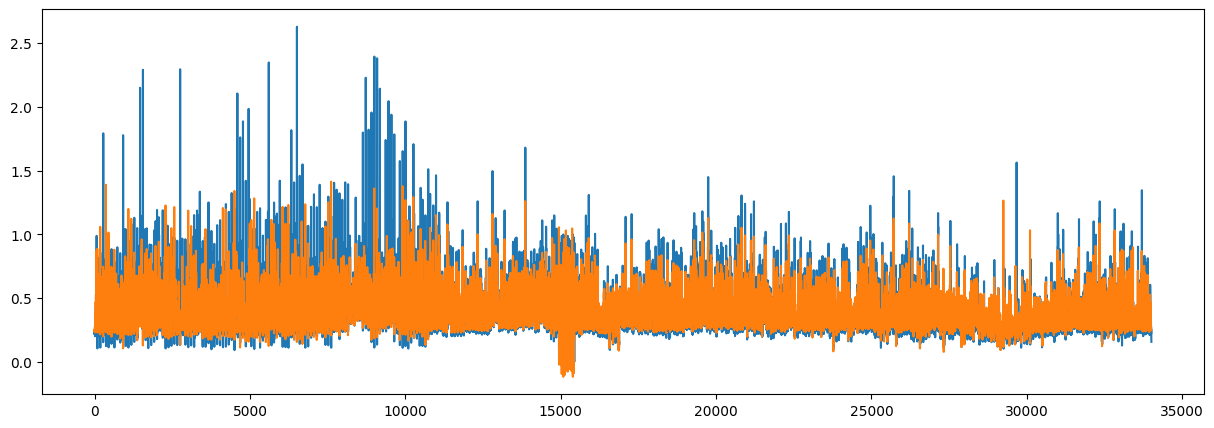

In [30]:
plt.figure(figsize=(15,5))

plt.plot(timeseries)
plt.plot(y_pred)

In [45]:
y_test = pd.read_csv('../data/test.csv')[['_value']]
y_train = pd.read_csv('../data/train.csv')[['_value']]

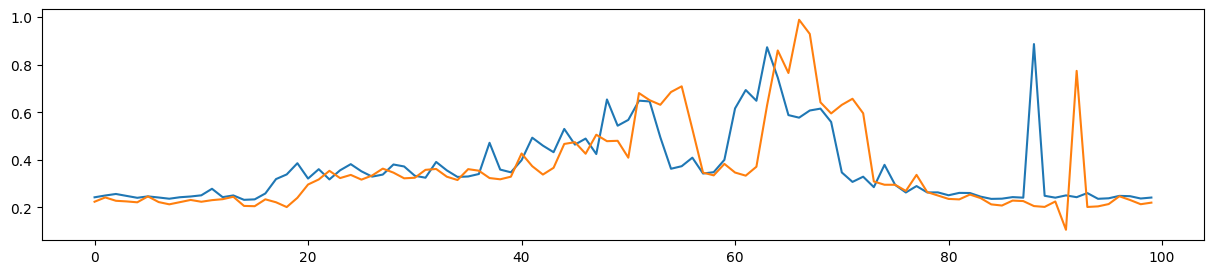

In [47]:
plt.figure(figsize=(15,3))
plt.plot(y_pred_train[:100])
plt.plot(y_train[:100])

In [38]:
torch.save(model.state_dict(), '../saved_models/lstm_w4.pt')